In [21]:
import numpy as np
import matplotlib.pyplot as plt

from framework_pkg.framework import FrameWork

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['text.usetex']=True
plt.style.use('classic')


frame_spectrum  = FrameWork(add='./Data/time_exposures.txt' ,threshold=3.5,
                            efficiency_correction=False,
                            resolution_correction=True,
                                   )

spectrum_data = frame_spectrum.spectrum_data
energy_obs    = frame_spectrum.energy_obs



param ={'SinT12'    : 0.308,
        'mu1'       : 0.,
        'mu2'       : 0.0, 
        'mu3'       : 0.  ,
        'mdm'       : 4.98 * 2e-4, 
        'alpha'     : 2.39  , #0-pi
        'eps'       : 0.  , #0-1
        'alpha_eps' : 2.32  , #0-pi
        'M12'       : 7.22e-5 }



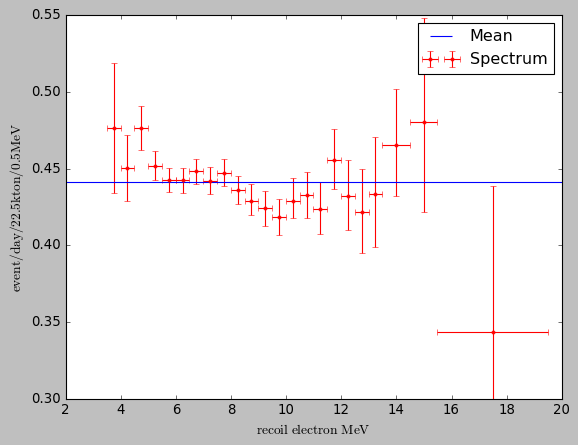

In [22]:
"""data illustration : B8 and hep
in comparsion with Fig 37 in paper Phys. Rev. D 109, 092001 (2024).
"""

spectrum_data = frame_spectrum.spectrum_data
energy_obs    = frame_spectrum.energy_obs

plt.ylim(0.3,0.55)
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')

plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), spectrum_data[:,2] / (spectrum_data[:,11] + spectrum_data[:,12]),
             yerr = np.array([spectrum_data[:,4], spectrum_data[:,3]]) / (spectrum_data[:,11] + spectrum_data[:,12]), 
             xerr = 0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='r.')

plt.hlines(xmin=2,xmax=20,y=0.441)

plt.legend(['Mean','Spectrum'])

<ErrorbarContainer object of 3 artists>

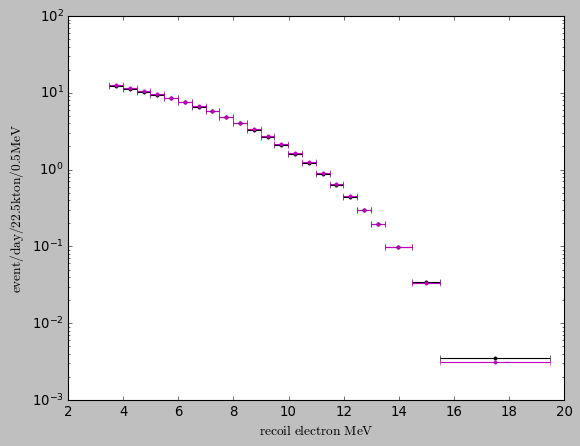

In [23]:
"""
Comparsion between our predection and the Fig36 in paper Phys. Rev. D 109, 092001 (2024).
expected B8 spectrum assuming no oscilation.
"""

b_un_per_day  = frame_spectrum.unoscillated_expected_spectrum

plt.yscale('log')
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')
plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), (0.5 / (energy_obs[:,1] - energy_obs[:,0])) * spectrum_data[:,11] * 22.5 / 365.25,
             yerr=None, xerr = 0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='k.' )
plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), (0.5 / (energy_obs[:,1] - energy_obs[:,0])) * b_un_per_day ,
             yerr=None, xerr = 0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='m.')


In [30]:
def prediction_prepration(frame_spectrum, param):
    predicted_spectrum = frame_spectrum.__getitem__(param)

    daily_exposure, R_daily = frame_spectrum._result_daily_basis(predicted_spectrum)
    
    periods = frame_spectrum.time_periods
    num_periods = len(periods)
    num_states = frame_spectrum.weight.shape[0]
    num_days = frame_spectrum.time_day.shape[0]

    periods_exposure = np.zeros((num_periods, num_days))
    R_periods = np.zeros((num_periods, num_days, num_states))

    for i in range (num_periods):
        periods_exposure[i] = frame_spectrum.time_day[:,2+i]
        for j in range(num_states):
            R_periods[i,:,j] = predicted_spectrum[periods[i]][:,j]


    R_day_daily = R_periods[0]
    R_night_daily = R_periods[1]
    day_exposure = periods_exposure[0]
    night_exposure = periods_exposure[1]

    time_bins = np.array([1])
    prediction = [R_day_daily, R_daily, R_night_daily]
    T_k = [day_exposure, daily_exposure, night_exposure]

    bin_prediction = np.zeros((len(prediction), len(time_bins), num_states))
    for i in range(len(time_bins)):
        cond = frame_spectrum.time_day[:,0] == time_bins[i]
        for k in range (num_states):
            for j in range (len(prediction)):
                bin_prediction[j,i,k] = (1/np.sum(T_k[j][cond])) * np.sum(T_k[j][cond] * prediction[j][cond,k])

    return bin_prediction

In [31]:
a_best = np.loadtxt('./Data/best_fit_8_7.txt')
param['SinT12'] = a_best[0]
param['M12'] = a_best[1] * 1e-5
param['mu2'] = a_best[2]
param['alpha'] = a_best[3]
param['eps'] = a_best[4]
param['alpha_eps'] = a_best[5]
param['mdm'] = a_best[7] * 2e-4


bin_prediction = prediction_prepration(frame_spectrum, param)


In [43]:
param['SinT12'] = 0.319
param['M12'] = 7.51 * 1e-5
param['mu2'] = 0
param['alpha'] = 0
param['eps'] = 0
param['alpha_eps'] = 0
param['mdm'] = a_best[7] * 2e-4


bin_prediction_2 = prediction_prepration(frame_spectrum, param)

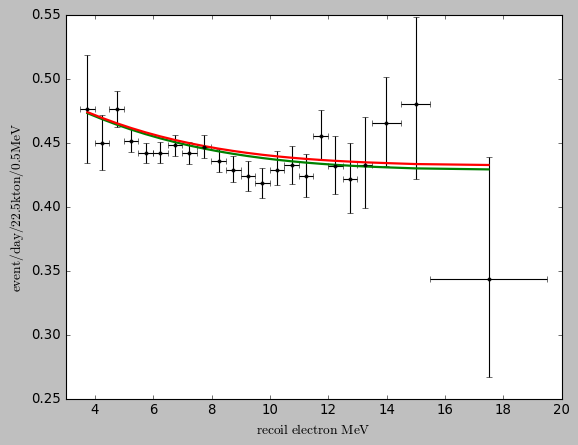

In [44]:
#plt.ylim(0.4,0.55)
plt.xlim(3,20)
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')

plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), spectrum_data[:,2] / (spectrum_data[:,11] + spectrum_data[:,12]),
             yerr = np.array([spectrum_data[:,4], spectrum_data[:,3]]) / (spectrum_data[:,11] + spectrum_data[:,12]), 
             xerr = 0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='k.')


plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), bin_prediction[1,0], lw=2, color='g')
plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), bin_prediction_2[1,0], lw=2, color='r')



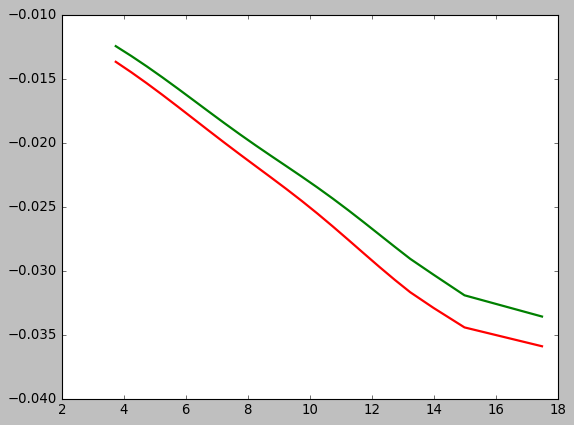

In [45]:
a_symmetry = np.zeros(energy_obs .shape[0])
a_symmetry2 = np.zeros(energy_obs .shape[0])
for k in range (energy_obs.shape[0]):
    a_symmetry[k] = 2 * (bin_prediction[0,0,k] - bin_prediction[2,0,k]) / (bin_prediction[0,0,k] + bin_prediction[2,0,k])
    a_symmetry2[k] = 2 * (bin_prediction_2[0,0,k] - bin_prediction_2[2,0,k]) / (bin_prediction_2[0,0,k] + bin_prediction_2[2,0,k])


plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), a_symmetry, lw=2, color='g')
plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), a_symmetry2, lw=2, color='r')

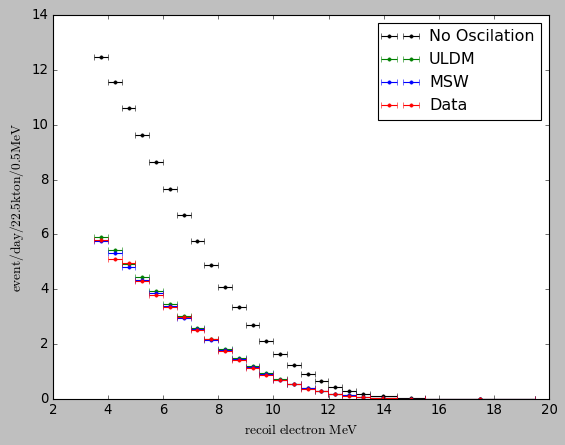

In [37]:

"""
B8 spectrum predection
"""

spectrum_event_per_day = (bin_prediction[1,0] * 
                          frame_spectrum.total_volume *
                          frame_spectrum.SNO_norm *
                          frame_spectrum.target_number *
                          frame_spectrum.unoscillated_term
)

spectrum_event_per_day2 = (bin_prediction_2[1,0] * 
                          frame_spectrum.total_volume *
                          frame_spectrum.SNO_norm *
                          frame_spectrum.target_number *
                          frame_spectrum.unoscillated_term
)

#plt.yscale('log')
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')

plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * b_un_per_day,
             yerr=None,  xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='k.')

plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * spectrum_event_per_day,
             yerr=None, xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='g.')


plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * spectrum_event_per_day2,
             yerr=None, xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='b.')


plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * spectrum_data[:,2] * 22.5 / 365.25 ,
             yerr=None,  xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='r.')

plt.legend(['No Oscilation', 'ULDM', 'MSW', 'Data'])



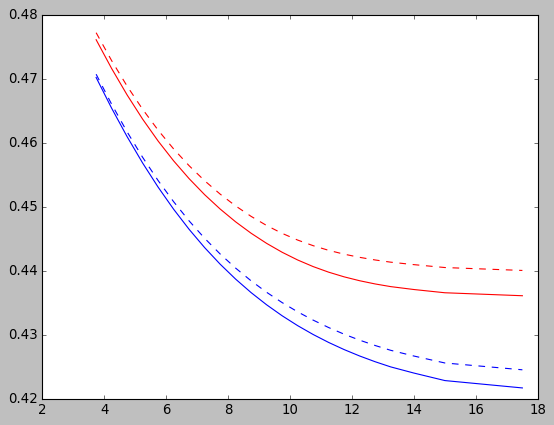

In [46]:
plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), bin_prediction[0,0], lw=1, color='b')
plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), bin_prediction[2,0], lw=1, color='r')


plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), bin_prediction_2[0,0], lw=1,ls='--', color='b')
plt.plot(0.5 * (energy_obs[:,1] + energy_obs[:,0]), bin_prediction_2[2,0], lw=1,ls='--', color='r')